# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
import statsmodels.api as sm
import seaborn as sns
import matplotlib.patches as mpatches
import pandas_profiling as pdp
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from IPython.display import clear_output
from six.moves import urllib
from __future__ import absolute_import, division, print_function, unicode_literals

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Dataset

In [ ]:
from pandas import read_csv
df= pd.read_csv('onlinedeliverydata.csv')
df


Age  Gender Marital Status Occupation  Monthly Income  \
0     20  Female         Single    Student       No Income   
1     24  Female         Single    Student  Below Rs.10000   
2     22    Male         Single    Student  Below Rs.10000   
3     22  Female         Single    Student       No Income   
4     22    Male         Single    Student  Below Rs.10000   
..   ...     ...            ...        ...             ...   
383   23  Female         Single    Student       No Income   
384   23  Female         Single    Student       No Income   
385   22  Female         Single    Student       No Income   
386   23    Male         Single    Student  Below Rs.10000   
387   23    Male         Single    Student       No Income   

    Educational Qualifications  Family size  latitude  longitude  Pin code  \
0                Post Graduate            4   12.9766    77.5993    560001   
1                     Graduate            3   12.9770    77.5773    560009   
2                Post Graduate            3   12.9551    77.6593    560017   
3                     Graduate            6   12.9473    77.5616    560019   
4                Post Graduate            4   12.9850    77.5533    560010   
..                         ...          ...       ...        ...       ...   
383              Post Graduate            2   12.9766    77.5993    560001   
384              Post Graduate            4   12.9854    77.7081    560048   
385              Post Graduate            5   12.9850    77.5533    560010   
386              Post Graduate            2   12.9770    77.5773    560009   
387              Post Graduate            5   12.8988    77.5764    560078   

     ...    Less Delivery time High Quality of package       Number of calls  \
0    ...  Moderately Important    Moderately Important  Moderately Important   
1    ...        Very Important          Very Important        Very Important   
2    ...             Important          Very Important  Moderately Important   
3    ...        Very Important               Important  Moderately Important   
4    ...             Important               Important  Moderately Important   
..   ...                   ...                     ...                   ...   
383  ...             Important               Important             Important   
384  ...  Moderately Important          Very Important  Moderately Important   
385  ...             Important          Very Important             Important   
386  ...             Important          Very Important             Important   
387  ...    Slightly Important             Unimportant    Slightly Important   

               Politeness            Freshness            Temperature  \
0    Moderately Important  Moderately Important  Moderately Important   
1          Very Important        Very Important        Very Important   
2          Very Important        Very Important             Important   
3          Very Important        Very Important        Very Important   
4               Important             Important             Important   
..                    ...                   ...                   ...   
383             Important             Important             Important   
384  Moderately Important  Moderately Important  Moderately Important   
385             Important        Very Important        Very Important   
386        Very Important        Very Important             Important   
387  Moderately Important  Moderately Important  Moderately Important   

              Good Taste          Good Quantity Output  \
0    Moderately Important  Moderately Important    Yes   
1          Very Important        Very Important    Yes   
2          Very Important  Moderately Important    Yes   
3          Very Important             Important    Yes   
4          Very Important        Very Important    Yes   
..                    ...                   ...    ...   
383             Important             Important    Yes   
384        Very Impor

# Dataset report

In [ ]:
! pip uninstall pandas-profiling

Found existing installation: pandas-profiling 3.2.0
Uninstalling pandas-profiling-3.2.0:
  Would remove:
    /usr/local/bin/pandas_profiling
    /usr/local/lib/python3.7/dist-packages/pandas_profiling-3.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas_profiling/*
Proceed (y/n)? y
  Successfully uninstalled pandas-profiling-3.2.0


In [ ]:
!pip install -q sklearn
%tensorflow_version 2.x
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip/
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
from pandas_profiling import ProfileReport

In [ ]:
# import pandas as pd
# import pandas_profiling as pp

# profile = pp.ProfileReport(df)
profile = pdp.ProfileReport(df, title='Heart Disease', html={'style':{'full_width':True}})
# profile.to_file("output.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Geospatial Analysis

In [8]:
! pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
%matplotlib inline
import folium

x = df.groupby(['latitude', 'longitude', 'Pin code']).size().reset_index()
x.columns = ['latitude', 'longitude', 'pincode', 'frequency']
x.sort_values(by=['frequency'], ascending=False, inplace=True)

latitude = 12.972442
longitude = 77.580643
delivery_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, freq, pin in zip(x['latitude'], x['longitude'], x['frequency'], x['pincode']):
    folium.CircleMarker([lat, lon], radius=freq, 
                        popup = ('Pincode: ' + str(pin) + '<br>' 
                                 '# of customers: ' + str(freq)
                                ), 
                        tooltip='Click to expand',
                        color='b', 
                        fill_color='red', 
                        fill=True, 
                        fill_opacity=0.6).add_to(delivery_map)

delivery_map

# Categorical Grouping

In [ ]:
class CategoricalGrouping():
    
    def __init__(self, data, col1, col2):
        self.data = data  # Pandas dataframe
        self.col1 = col1  # Column with categories for analysis
        self.col2 = col2  # Output variable
        
    @property
    def table(self):
        return self.data.groupby([self.col1, self.col2]).size().reset_index().pivot(
            columns=self.col1, index=self.col2, values=0).fillna(0)


# Defining a function to plot a nested pie chart
def nested_piechart(data, axis, wedge_width, pie_colors, chart_title):
    """This function takes the following arguments:
        
        data: a pandas dataframe of dimension greater than 2x1 (row x column)
        axis: matplotlib.axes.Axes object for plotting
        wedge_width: float, should be <=1
        pie_colors: list, color codes in hex, should be >= maximum # of categories
        chart_title: str, chart title to display
        
    """

    # Outer wedges
    wedges_outer, texts_outer = axis.pie(data.iloc[1], radius=1, wedgeprops=dict(width=wedge_width, edgecolor='w'), 
           startangle=90, colors=pie_colors)

    # Inner wedges
    axis.pie(data.iloc[0], radius=(1-wedge_width), wedgeprops=dict(width=wedge_width, edgecolor='w', alpha=0.7), 
           startangle=90, colors=pie_colors)

    axis.set(aspect="equal", title=chart_title)

    axis.legend(wedges_outer, list(data.columns),
              title=chart_title,
              loc="lower center",
              bbox_to_anchor=(0.85, -0.1, 0.5, 1))

    # Defining properties for annotations
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    y = np.sin(np.deg2rad(120))  # Converting degrees to radians
    x = np.cos(np.deg2rad(120))  # Converting degrees to radians

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]  # Depending on the radians of x, will give -1 or 1
    connectionstyle = "angle,angleA=0,angleB={}".format(120)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})  # adding connection style args to kw dict
    axis.annotate(data.index[1], xy=(x, y), xytext=(1*np.sign(x), 1.2*y), 
                horizontalalignment=horizontalalignment, **kw)

    y = np.sin(np.deg2rad(140)) - 0.60  # Converting degrees to radians
    x = np.cos(np.deg2rad(140)) + 0.37  # Converting degrees to radians

    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]  # Depending on the radians of x, will give -1 or 1
    connectionstyle = "angle,angleA=0,angleB={}".format(140)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})  # adding connection style args to kw dict
    axis.annotate(data.index[0], xy=(x, y), xytext=(0.01*np.sign(x), -2*y), 
                horizontalalignment=horizontalalignment, **kw)

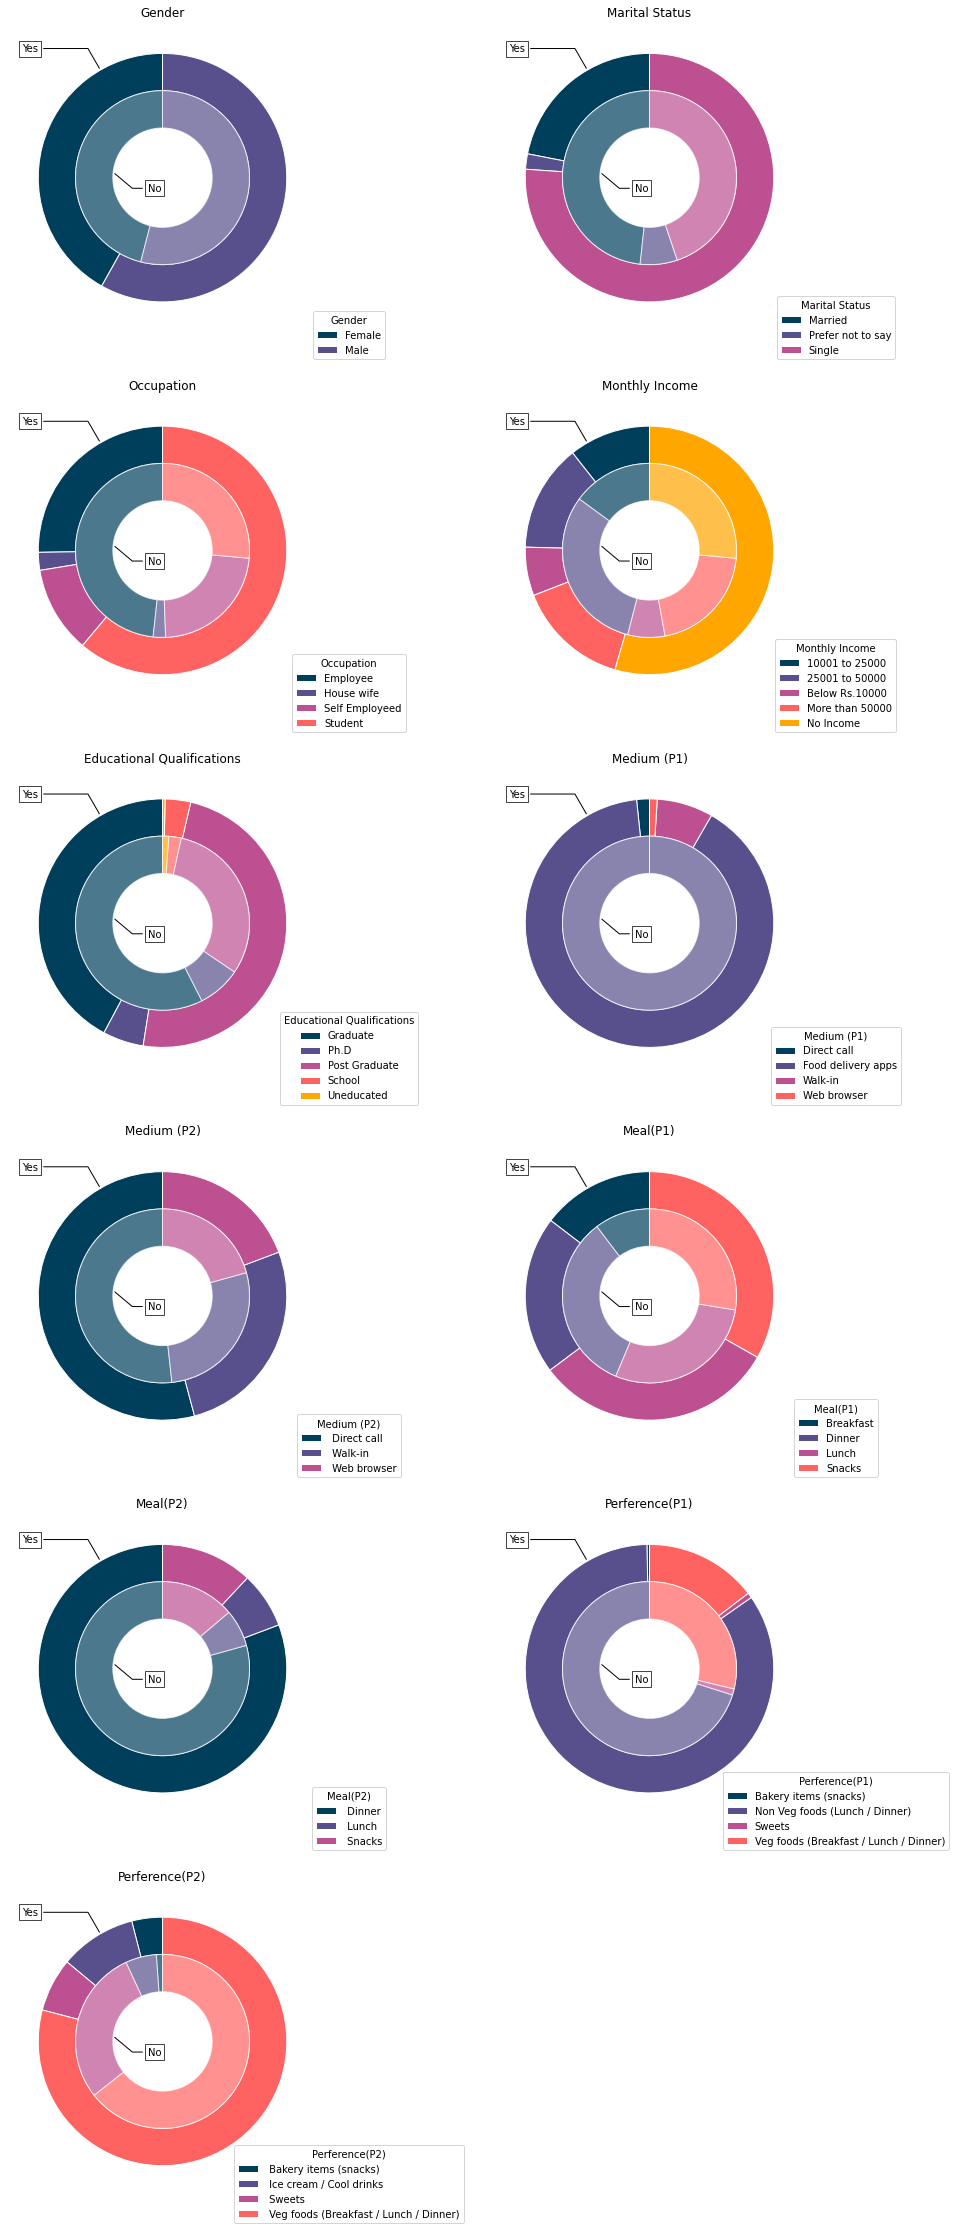

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=[16,40])

size = 0.3
c2 = 'Output'
c_palette = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

cat_var = ['Gender', 'Marital Status', 'Occupation', 'Monthly Income', 'Educational Qualifications', 'Medium (P1)', 
           'Medium (P2)', 'Meal(P1)', 'Meal(P2)', 'Perference(P1)', 'Perference(P2)']

ax_list = []

for ind, var in enumerate(cat_var):
    ax_list.append(fig.add_subplot(6, 2, (ind+1)))
    nested_piechart(CategoricalGrouping(data, var, c2).table, ax_list[ind], size, c_palette, var)
    

# Continuous Variables

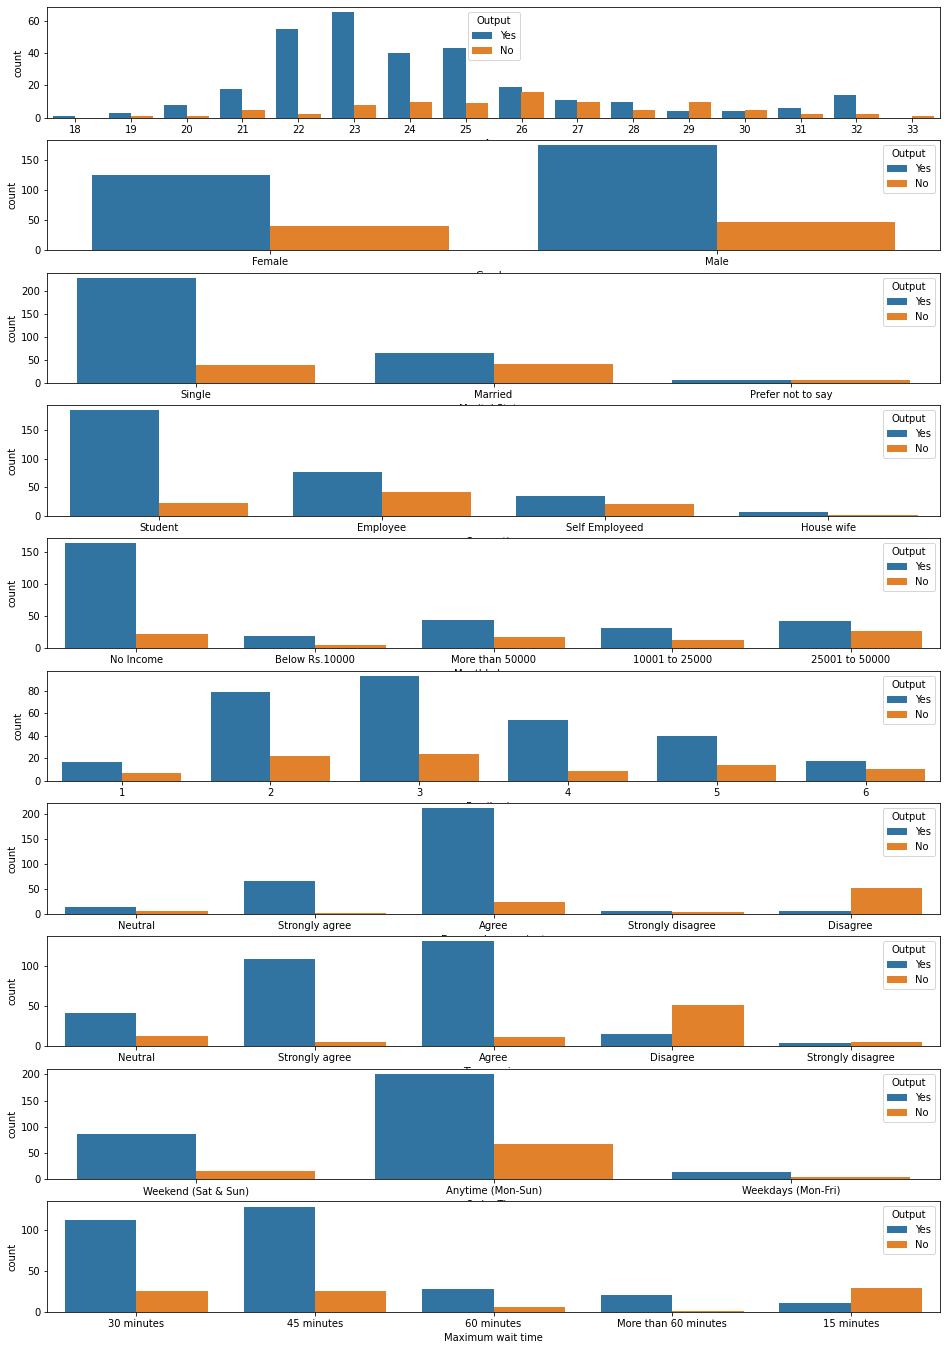

In [17]:
%matplotlib inline
cols=[0, 1, 2, 3, 4, 6, 16, 17, 37, 38]
cols1=list(enumerate([list(df.columns)[i] for i in cols], start=1))

fig = plt.figure(figsize=[16, 24])
for index, col_name in cols1:
  ax=fig.add_subplot(10, 1, index)
  sns.countplot(x=col_name, data=df, hue='Output')